In [1]:
!nvidia-smi

Wed May  4 16:41:02 2016       
+------------------------------------------------------+                       
| NVIDIA-SMI 364.19     Driver Version: 364.19         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970M    Off  | 0000:01:00.0     Off |                  N/A |
| N/A   38C    P8     1W /  N/A |     22MiB /  6143MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [176]:
%matplotlib inline

import os

# 3rd party
import numpy as np

import PIL.Image

import matplotlib.pyplot as plt

import cv2

# Our own imports
import dream_models
reload(dream_models)
from dream_models import DeepDream, caffe, showarray, ImageNet, FastRCNN, plot_detections, segment_guide_parts, find_box_correspondence

caffe.set_mode_gpu()
caffe.set_device(0)

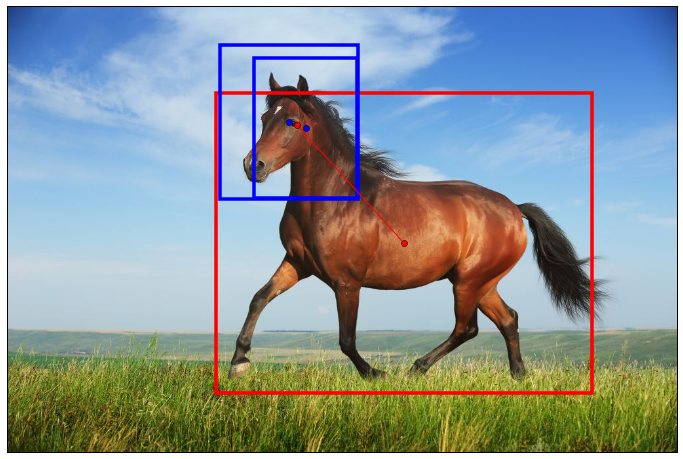

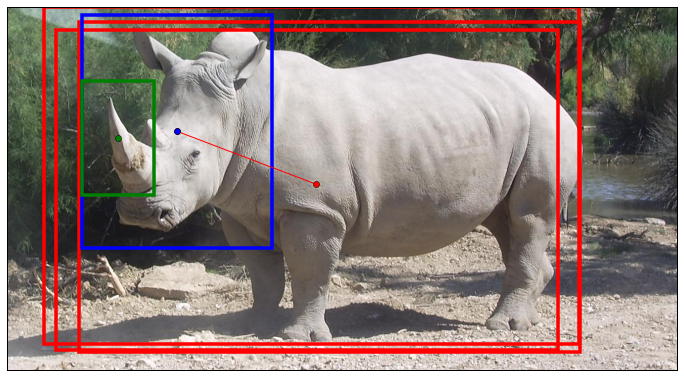

In [49]:
imagedb = ImageNet()

# baseimg_fn = imagedb.get_imagefile('horse')
# guideimg_fn = imagedb.get_imagefile('rhino')

rcnn_net = FastRCNN(conf_thresh=0.1)
rcnn_net.load()

base_boxes, base_head_boxes, base_axis = rcnn_net.find_main_axis(baseimg_fn)
guide_boxes, guide_head_boxes, guide_axis = rcnn_net.find_main_axis(guideimg_fn)
guide_parts = rcnn_net.lookup(guideimg_fn, 'horn')

plot_detections(baseimg_fn, base_boxes, head_boxes=base_head_boxes, img_axis=base_axis)
plot_detections(guideimg_fn, guide_boxes, head_boxes=guide_head_boxes, img_axis=guide_axis,
                guide_boxes=guide_parts)

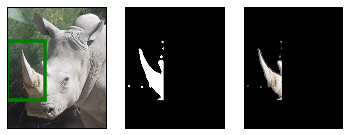

In [166]:
part_mask = segment_guide_parts(guideimg_fn, guide_parts)

# Plots for poster
guideimg  = np.array(PIL.Image.open(guideimg_fn))
baseimg = np.array(PIL.Image.open(baseimg_fn))

h0, h1, h2, h3 = np.round(guide_head_boxes[0]).astype(np.int)
g0, g1, g2, g3 = np.round(guide_parts[0]).astype(np.int)

fig, axes = plt.subplots(1, 3, subplot_kw={'xticks': [], 'yticks': []})
axes[0].imshow(guideimg[h1:h3, h0:h2])
axes[0].add_patch(
                plt.Rectangle((g0-h0, g1-h1),
                              g2 - g0,
                              g3 - g1, fill=False,
                              edgecolor='green', linewidth=3.5))
axes[1].imshow(part_mask[h1:h3, h0:h2], cmap='bone')

gimg = guideimg[h1:h3, h0:h2].copy()
gimg[..., 0] = gimg[..., 0] * part_mask[h1:h3, h0:h2]
gimg[..., 1] = gimg[..., 1] * part_mask[h1:h3, h0:h2]
gimg[..., 2] = gimg[..., 2] * part_mask[h1:h3, h0:h2]

axes[2].imshow(gimg)


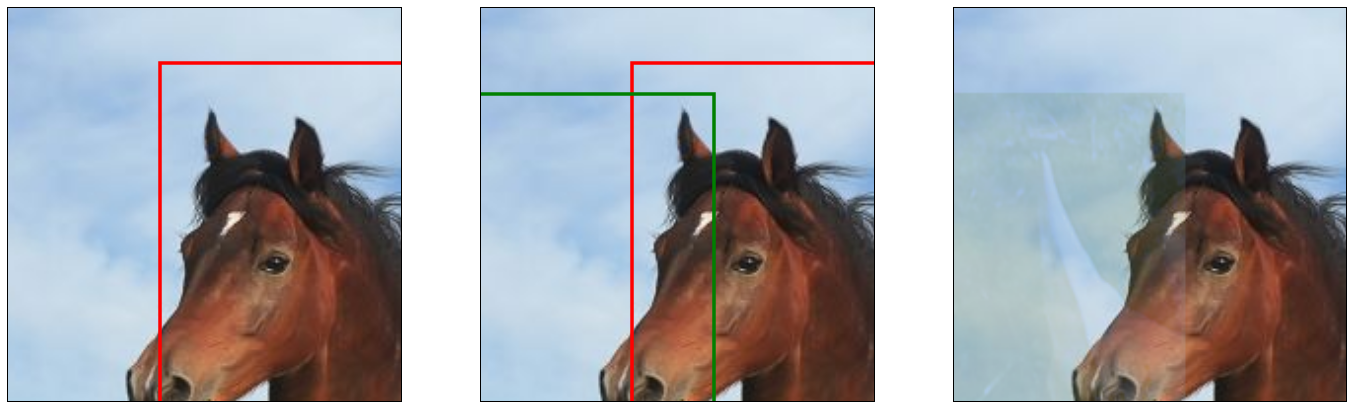

In [204]:
reload(dream_models)
from dream_models import find_box_correspondence, make_composite_image

# Plots for poster
guideimg  = np.array(PIL.Image.open(guideimg_fn))
baseimg = np.array(PIL.Image.open(baseimg_fn))

c0, c1, c2, c3 = 50, 300, 250, 500

h0, h1, h2, h3 = np.round(guide_head_boxes[0]).astype(np.int)
g0, g1, g2, g3 = np.round(guide_parts[0]).astype(np.int)

b0, b1, b2, b3 = np.round(base_head_boxes[0]).astype(np.int)
gb0, gb1, gb2, gb3 = find_box_correspondence(guide_head_boxes[0], guide_parts[0], base_head_boxes[0])

img, gimg = make_composite_image(baseimg, guideimg, [gb1, gb3, gb0, gb2],  [g1, g3, g0, g2], weight=0.9)

fig, axes = plt.subplots(1, 3, figsize=(24, 48), subplot_kw={'xticks': [], 'yticks': []})
axes[0].imshow(baseimg[c0:c2, c1:c3])
axes[0].add_patch(
    plt.Rectangle((b0-c1, b1-c0),
                   b2 - b0,
                   b3 - b1, fill=False,
                              edgecolor='red', linewidth=3.5))

axes[1].imshow(baseimg[c0:c2, c1:c3])
axes[1].add_patch(
    plt.Rectangle((b0-c1, b1-c0),
                   b2 - b0,
                   b3 - b1, fill=False,
                              edgecolor='red', linewidth=3.5))

axes[1].add_patch(
    plt.Rectangle((gb0-c1, gb1-c0),
                   gb2 - gb0,
                   gb3 - gb1, fill=False,
                              edgecolor='green', linewidth=3.5))

axes[2].imshow(img[c0:c2, c1:c3])





In [109]:
dream_net = DeepDream()
dream_net.load()

In [81]:
dream_net.end = 'inception_5b/output'
dream_net.set_guide(guideimg_fn)
img = np.float32(PIL.Image.open(baseimg_fn))

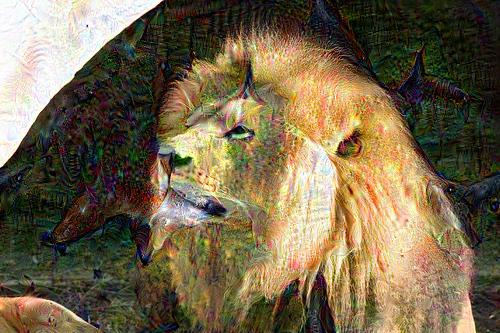

3 9 inception_5b/output (333, 500, 3)


In [82]:
for _ in range(3):
    img = dream_net.deepdream(img, iter_n=10)